In [1]:
import os
import sys
# sys.stdout.flush() # For progress bar to not print a new line everytime
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER') or '/home/fne23_stjarnholm/master-project'}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm

results = []

result_folders = run_tools.get_all_result_dirs()

# Loop over each run number and get the run settings as well as the k-effective
for result_folder in tqdm(result_folders):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    results.append(result)

100%|██████████| 1000/1000 [02:09<00:00,  7.74it/s]


In [2]:
# PLOT SETTINGS:
FAST_REACTOR = False # True if epithermal, False if thermal

folder_name = f"plots-FAST_REACTOR={FAST_REACTOR}"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}-FAST_REACTOR={FAST_REACTOR}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filter for FAST_REACTOR
df = df[df["FAST_REACTOR"] == FAST_REACTOR]

if df.empty:
    raise Exception("No results found!")

df.head()

,k-eff,k-eff-std,result_path,FAST_REACTOR,particle_count,active_batch_count,inactive_batch_count,t_start,t_end,t_elapsed,seed
0,0.988638,0.000315,../results/RUNDATA_R3_1,False,30000,300,50,1.675945e+09,1.675945e+09,130.051,2860012914
1,0.989758,0.000320,../results/RUNDATA_R3_2,False,30000,300,50,1.675945e+09,1.675945e+09,130.224,6264270049
2,0.989332,0.000315,../results/RUNDATA_R3_3,False,30000,300,50,1.675945e+09,1.675945e+09,129.413,9042365702
3,0.989287,0.000316,../results/RUNDATA_R3_4,False,30000,300,50,1.675945e+09,1.675945e+09,131.589,7065801283
4,0.989067,0.000325,../results/RUNDATA_R3_5,False,30000,300,50,1.675945e+09,1.675945e+09,134.809,6605963192


In [3]:
df["rel_err_k-eff-std"] = 100 * df["k-eff-std"] / df["k-eff"]

df["rho"] = (df["k-eff"] - 1) / df["k-eff"]
df["rho-std"] = df["k-eff-std"] / df["k-eff"]**2

df["rho-pcm"] = 1e5 * df["rho"]
df["rho-std-pcm"] = 1e5 * df["rho-std"]

df["rel-err_rho-std"] = np.abs(100 * df["rho-std"] / df["rho"])

df.head()

,k-eff,k-eff-std,result_path,FAST_REACTOR,particle_count,active_batch_count,inactive_batch_count,t_start,t_end,t_elapsed,seed,rel_err_k-eff-std,rho,rho-std,rho-pcm,rho-std-pcm,rel-err_rho-std
0,0.988638,0.000315,../results/RUNDATA_R3_1,False,30000,300,50,1.675945e+09,1.675945e+09,130.051,2860012914,0.031853,-0.011492,0.000322,-1149.230268,32.218731,2.803505
1,0.989758,0.000320,../results/RUNDATA_R3_2,False,30000,300,50,1.675945e+09,1.675945e+09,130.224,6264270049,0.032310,-0.010348,0.000326,-1034.800618,32.643953,3.154613
2,0.989332,0.000315,../results/RUNDATA_R3_3,False,30000,300,50,1.675945e+09,1.675945e+09,129.413,9042365702,0.031845,-0.010783,0.000322,-1078.279667,32.187883,2.985115
3,0.989287,0.000316,../results/RUNDATA_R3_4,False,30000,300,50,1.675945e+09,1.675945e+09,131.589,7065801283,0.031927,-0.010829,0.000323,-1082.897195,32.273036,2.980249
4,0.989067,0.000325,../results/RUNDATA_R3_5,False,30000,300,50,1.675945e+09,1.675945e+09,134.809,6605963192,0.032905,-0.011054,0.000333,-1105.396538,33.268884,3.009679


In [7]:
def gaussian(x, a, x_0, sigma):
    return a * np.exp(-((x - x_0)**2) / (2 * sigma**2))

from scipy.optimize import curve_fit
def fit_gaussian_to_histogram(ax: plt.Axes, p0: list, decimals: int, plot: bool = True):
    x = np.array([p.get_x() for p in ax.patches]) + ax.patches[0].get_width() / 2 # Get the center of each bin
    y = np.array([p.get_height() for p in ax.patches]) # Get the height of each bin
    popt, pcov = curve_fit(gaussian, x, y, p0=p0)

    if plot:
        # Get the current x limits of the plot
        x_min, x_max = ax.get_xlim()
        x_fit = np.linspace(x_min, x_max, 1000)
        y_fit = gaussian(x_fit, *popt)
        ax.autoscale(False, axis="x")
        mu = f"{popt[1]:.{decimals}f}"
        sigma = f"{np.abs(popt[2]):.{decimals}f}"
        plt.plot(x_fit, y_fit, linestyle="solid", linewidth=2, label=f"Gaussian fit\n$\mu={mu}$\n$\sigma={sigma}$")

    return popt, pcov



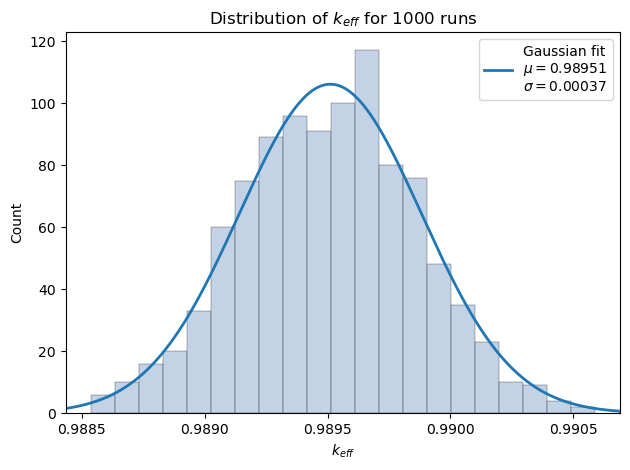

In [8]:
ax = sns.histplot(df["k-eff"], linewidth=0.2, color="lightsteelblue")
plt.title(f"Distribution of $k_{{eff}}$ for {len(df)} runs")
plt.xlabel("$k_{eff}$")
plt.ylabel("Count")

# Fit a Gaussian to the histogram heights
popt, pcov = fit_gaussian_to_histogram(ax, p0=[1, np.mean(df["k-eff"]), np.mean(df["k-eff-std"])], decimals=5)

plt.legend()
plt.tight_layout()
plt.savefig(get_filename("heatmap", "distribution-k_eff"))

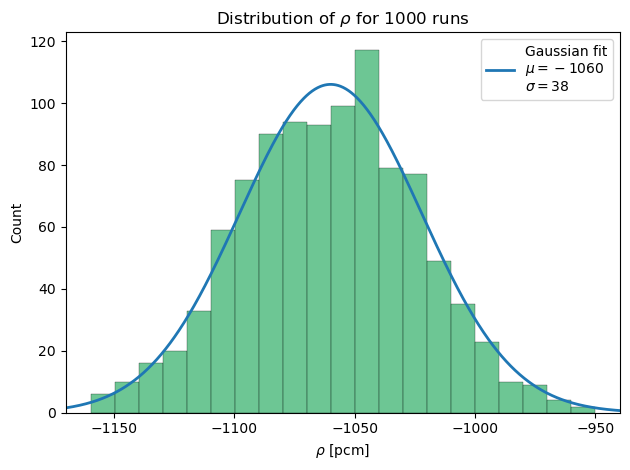

In [9]:
ax = sns.histplot(df["rho-pcm"], linewidth=0.2, color="mediumseagreen")
plt.title(fr"Distribution of $\rho$ for {len(df)} runs")
plt.xlabel(r"$\rho$ [pcm]")
plt.ylabel("Count")

# Fit a Gaussian to the histogram heights
popt, pcov = fit_gaussian_to_histogram(ax, p0=[1, np.mean(df["rho-pcm"]), np.mean(df["rho-std-pcm"])], decimals=0)

plt.legend()
plt.tight_layout()
plt.savefig(get_filename("heatmap", "distribution-rho"))
